# 0. Preparação do Ambiente

In [44]:
import math
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Cleaning

### Pre-Cleaning

In [2]:
data = pd.read_feather('credit_scoring.ftr')

In [3]:
data.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [4]:
data.drop_duplicates(inplace=True)
data.drop(columns='index', inplace=True)
print(data.shape)

(280339, 14)


In [5]:
null_counts = data.isnull().sum()
missing_counts = data.isna().sum()

print('Null Data')
print(null_counts)

Null Data
data_ref                     0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            47609
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64


In [6]:
print('Missing Data')
print(missing_counts)

Missing Data
data_ref                     0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            47609
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64


### Outliers

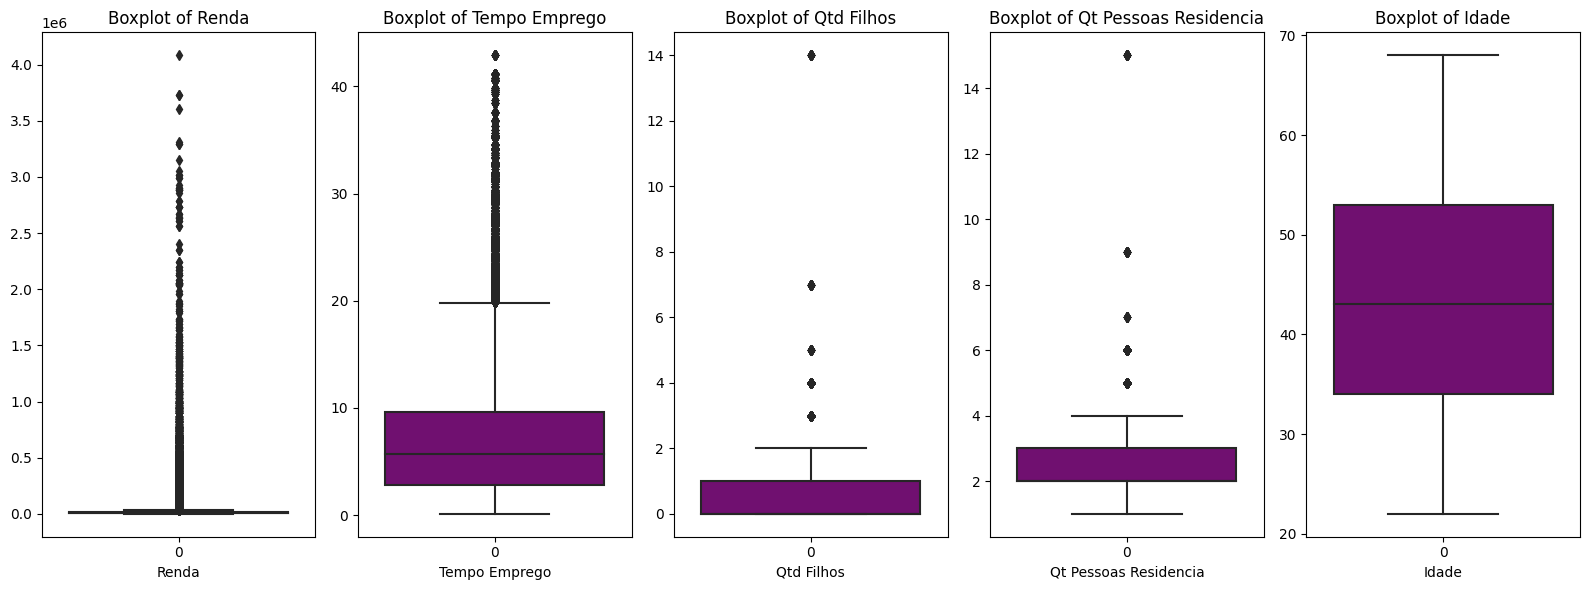

In [7]:
# Set the color you want (e.g., 'purple')
box_color = 'purple'

# Create a figure with four subplots
plt.figure(figsize=(16, 6))

# First subplot for 'renda'
plt.subplot(1, 5, 1)
sns.boxplot(data['renda'], color=box_color)
plt.title('Boxplot of Renda')
plt.xlabel('Renda')

# Second subplot for 'tempo_emprego'
plt.subplot(1, 5, 2)
sns.boxplot(data['tempo_emprego'], color=box_color)
plt.title('Boxplot of Tempo Emprego')
plt.xlabel('Tempo Emprego')

# Third subplot for 'qtd_filhos'
plt.subplot(1, 5, 3)
sns.boxplot(data['qtd_filhos'], color=box_color)
plt.title('Boxplot of Qtd Filhos')
plt.xlabel('Qtd Filhos')

# Fourth subplot for 'qt_pessoas_residencia'
plt.subplot(1, 5, 4)
sns.boxplot(data['qt_pessoas_residencia'], color=box_color)
plt.title('Boxplot of Qt Pessoas Residencia')
plt.xlabel('Qt Pessoas Residencia')

# Fith subplot for 'idade'
plt.subplot(1, 5, 5)
sns.boxplot(data['idade'], color=box_color)
plt.title('Boxplot of Idade')
plt.xlabel('Idade')

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

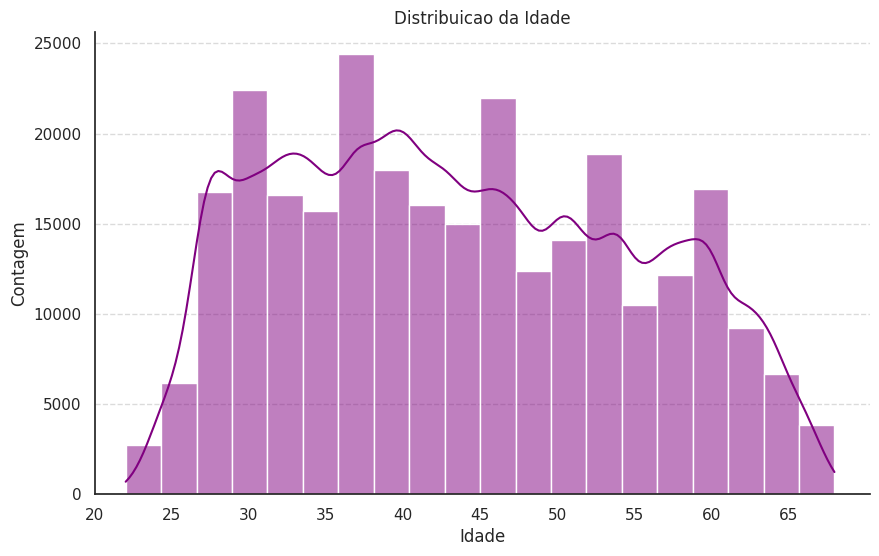

In [12]:
# Set the color you want (e.g., 'blue')
hist_color = 'purple'

# Set seaborn style
sns.set(style='white')

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data['idade'], color=hist_color, bins=20, kde=True)  # With KDE for a smoothed line
plt.title('Distribuicao da Idade')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.xticks(range(0, max(data['idade']) + 1, 5))  # Customize x-axis ticks

# Add grid and remove right and top spines
sns.despine()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xlim(20,)

# Show the plot
plt.tight_layout
plt.show()

In [75]:
data.idade.describe()

count    280339.000000
mean         43.679374
std          11.288456
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64

### Amostragem

In [9]:
# Get the maximum date in the dataset
max_date = data['data_ref'].max()

# Calculate the start date for the last three months
start_date = max_date - pd.DateOffset(months=3)

# Filter the data for the last three months
# Validation out of time (oot)
data_oot = data[(data['data_ref'] >= start_date) & (data['data_ref'] <= max_date)]

# Filter the rows to be removed (last three months data)
rows_to_remove = data[(data['data_ref'] >= start_date) & (data['data_ref'] <= max_date)].index

# Remove the rows from the original dataset
data_cleaned = data.drop(rows_to_remove)

# Data Exploration

### Descritiva básica univariada

In [10]:
# Get the count of rows for each month in 'data_ref'
monthly_counts = data_cleaned['data_ref'].dt.to_period('M').value_counts().sort_index()

# Define a list of month names
month_names = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov"]

# Print the number of rows for each month
print("Numero de registros para cada mes:")
for period, count in monthly_counts.items():
    print(f"{month_names[period.month - 1]} {period.year}: {count}")

Numero de registros para cada mes:
Jan 2015: 20066
Fev 2015: 19428
Mar 2015: 18714
Abr 2015: 17993
Mai 2015: 17398
Jun 2015: 17091
Jul 2015: 16998
Ago 2015: 17100
Set 2015: 17417
Out 2015: 17948
Nov 2015: 18793


### Variaveis Qualitativas

In [ ]:
# Basic univariate analysis for quantitative variables
quantitative_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

#### Tempo de emprego

In [17]:
data.tempo_emprego.describe()

count    232730.000000
mean          7.326544
std           6.424824
min           0.117808
25%           2.794521
50%           5.676712
75%           9.610959
max          42.906849
Name: tempo_emprego, dtype: float64

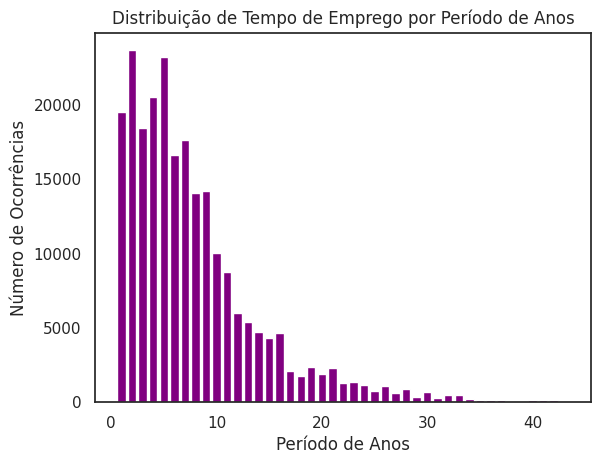

In [33]:
# Arredondar os valores para obter os períodos de anos
data['tempo_emprego_anos'] = data['tempo_emprego'].dropna().apply(lambda x: math.ceil(x))

# Contar o número de ocorrências em cada período de anos
period_counts = data['tempo_emprego_anos'].value_counts().sort_index()

# Plotar um gráfico de barras dos períodos de anos
plt.bar(period_counts.index, period_counts.values, color = 'purple')
plt.xlabel('Período de Anos')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Tempo de Emprego por Período de Anos')
plt.show()

A análise da variável "tempo_emprego" revela uma distribuição que sugere um padrão claro na experiência dos trabalhadores. A grande maioria dos indivíduos apresenta uma faixa de tempo de emprego entre 0 e 10 anos, indicando que a maioria dos profissionais está relativamente no início de suas carreiras. Isso pode ser associado a uma possível rotatividade de pessoal ou a um mercado de trabalho que frequentemente recebe novos profissionais. Por outro lado, uma observação notável é que há poucos trabalhadores que acumularam mais de 20 anos de experiência. Esse grupo pode representar profissionais mais experientes e talvez sejam os líderes ou especialistas em suas áreas, cuja experiência prolongada pode ser altamente valorizada por suas organizações. A disparidade entre essas duas categorias sugere uma distribuição assimétrica, com um pico na faixa mais baixa e uma cauda longa na faixa mais alta, o que pode influenciar a dinâmica do mercado de trabalho e as oportunidades de crescimento profissional.

#### Renda

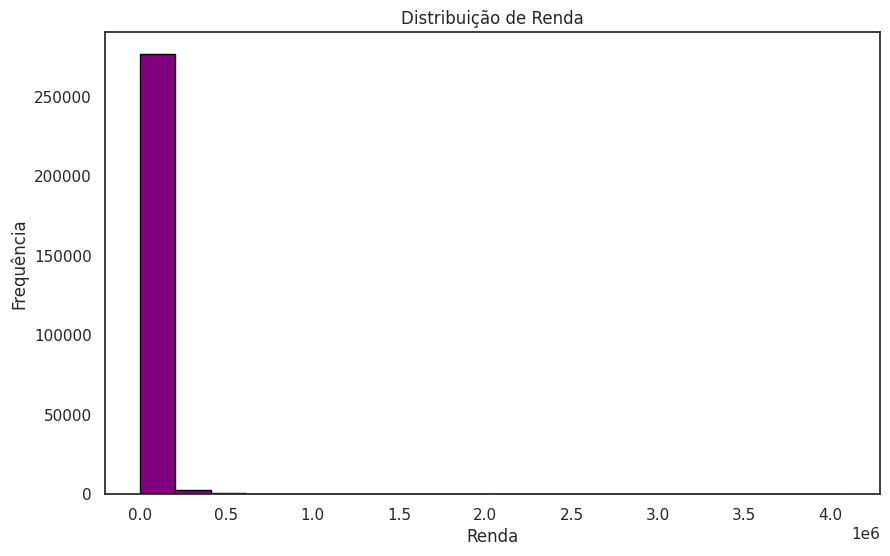

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(data['renda'], bins=20, color='purple', edgecolor='black')
plt.xlabel('Renda')
plt.ylabel('Frequência')
plt.title('Distribuição de Renda')
plt.show()

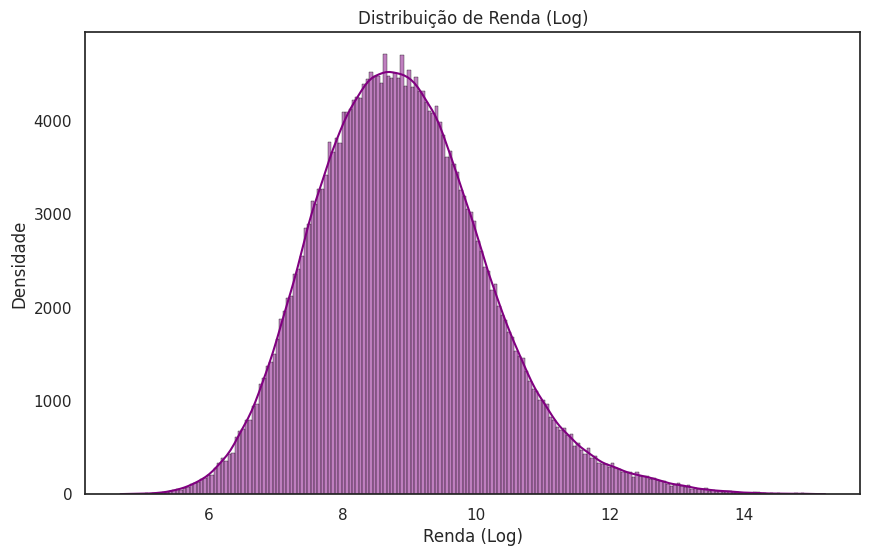

In [50]:
# Aplicar transformação logarítmica à variável de renda
data['renda_log'] = np.log(data['renda'])

plt.figure(figsize=(10, 6))
sns.histplot(data['renda_log'], kde=True, color='purple', edgecolor='black')
plt.xlabel('Renda (Log)')
plt.ylabel('Densidade')
plt.title('Distribuição de Renda (Log)')

plt.show()

A análise da distribuição da renda, após a aplicação da transformação logarítmica, revela uma característica simétrica notável. A curva de densidade exibe uma forma equilibrada, com um pico pronunciado ocorrendo em torno de $8000,00. Essa simetria sugere que os valores de renda estão distribuídos uniformemente em ambos os lados da média, o que pode ser indicativo de uma distribuição mais balanceada em termos de distribuição de renda. No entanto, é importante notar que, apesar da simetria central, a distribuição possui uma cauda longa que se estende além de $1200000,00. Isso implica que existem valores de renda relativamente raros ou atípicos, que se afastam consideravelmente da maioria dos dados. Essa cauda estendida pode indicar a presença de indivíduos ou famílias com rendimentos substancialmente elevados, o que contribui para uma maior variabilidade na distribuição.

### Variaveis Quantitivas

In [ ]:
# Basic univariate analysis for categorical variables
categorical_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']

#### Sexo

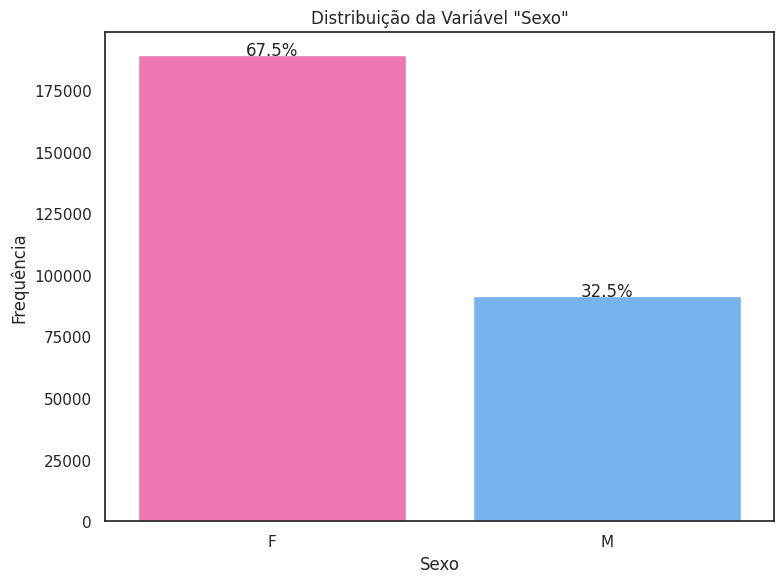

In [59]:
# Personalizar paleta de cores
colors = ["#FF66B2", "#66B3FF"]

plt.figure(figsize=(8, 6))
sns.countplot(x='sexo', data=data, palette=colors)
plt.xlabel('Sexo')
plt.ylabel('Frequência')
plt.title('Distribuição da Variável "Sexo"')

# Adicionar porcentagens nas barras
total = len(data['sexo'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

# Ajustar layout
plt.tight_layout()
plt.show()

#### Posse de Veiculo

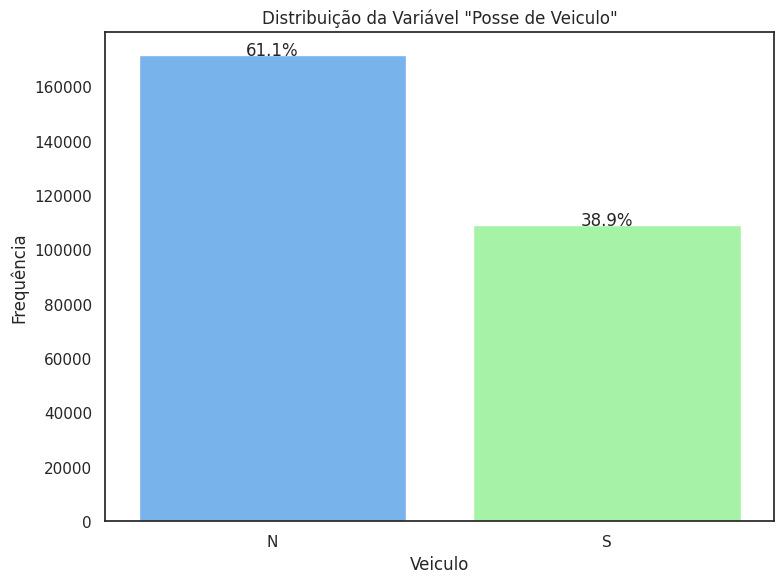

In [62]:
# Personalizar paleta de cores
colors = ["#66b3ff", "#99ff99"]

plt.figure(figsize=(8, 6))
sns.countplot(x='posse_de_veiculo', data=data, palette=colors)
plt.xlabel('Veiculo')
plt.ylabel('Frequência')
plt.title('Distribuição da Variável "Posse de Veiculo"')

# Adicionar porcentagens nas barras
total = len(data['posse_de_veiculo'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

# Ajustar layout
plt.tight_layout()
plt.show()

#### Posse de Imovel

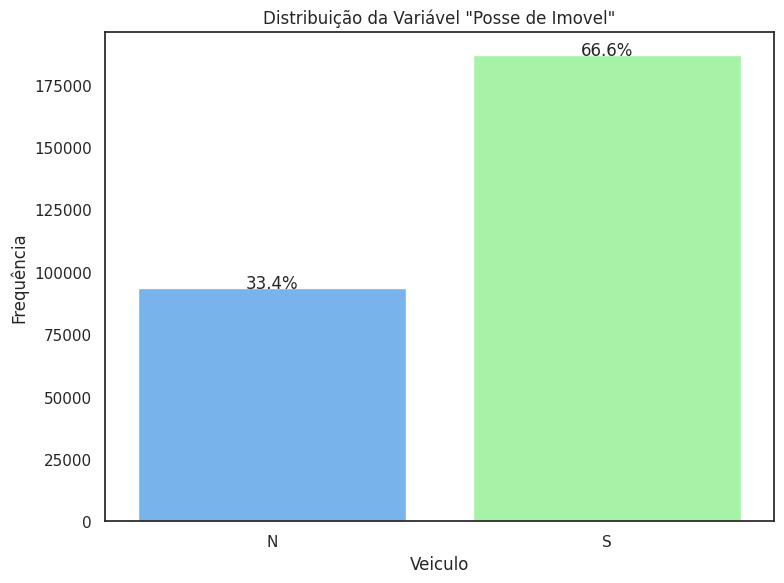

In [63]:
# Personalizar paleta de cores
colors = ["#66b3ff", "#99ff99"]

plt.figure(figsize=(8, 6))
sns.countplot(x='posse_de_imovel', data=data, palette=colors)
plt.xlabel('Veiculo')
plt.ylabel('Frequência')
plt.title('Distribuição da Variável "Posse de Imovel"')

# Adicionar porcentagens nas barras
total = len(data['posse_de_imovel'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

# Ajustar layout
plt.tight_layout()
plt.show()

#### Tipo de Renda

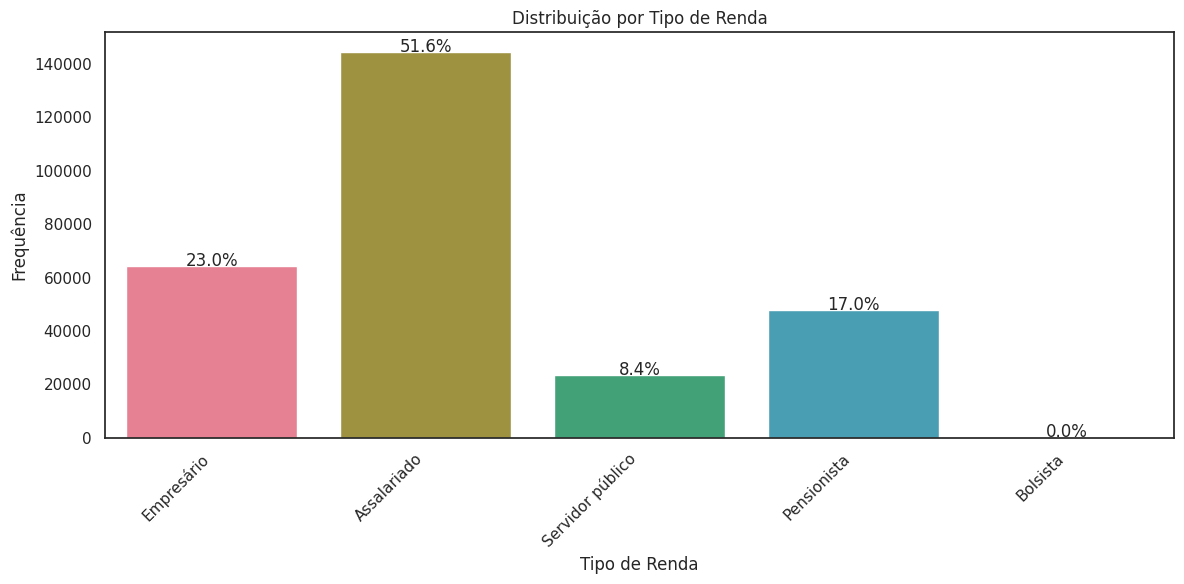

In [74]:
# Definir paleta de cores customizada
colors = sns.color_palette("husl", n_colors=len(data['tipo_renda'].unique()))

plt.figure(figsize=(12, 6))
sns.countplot(x='tipo_renda', data=data, palette=colors)
plt.xlabel('Tipo de Renda')
plt.ylabel('Frequência')
plt.title('Distribuição por Tipo de Renda')

# Rotacionar rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Adicionar porcentagens nas barras
total = len(data['tipo_renda'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

# Ajustar layout
plt.tight_layout()

plt.show()

In [68]:
data.tipo_renda.unique()

array(['Empresário', 'Assalariado', 'Servidor público', 'Pensionista',
       'Bolsista'], dtype=object)

#### Educação

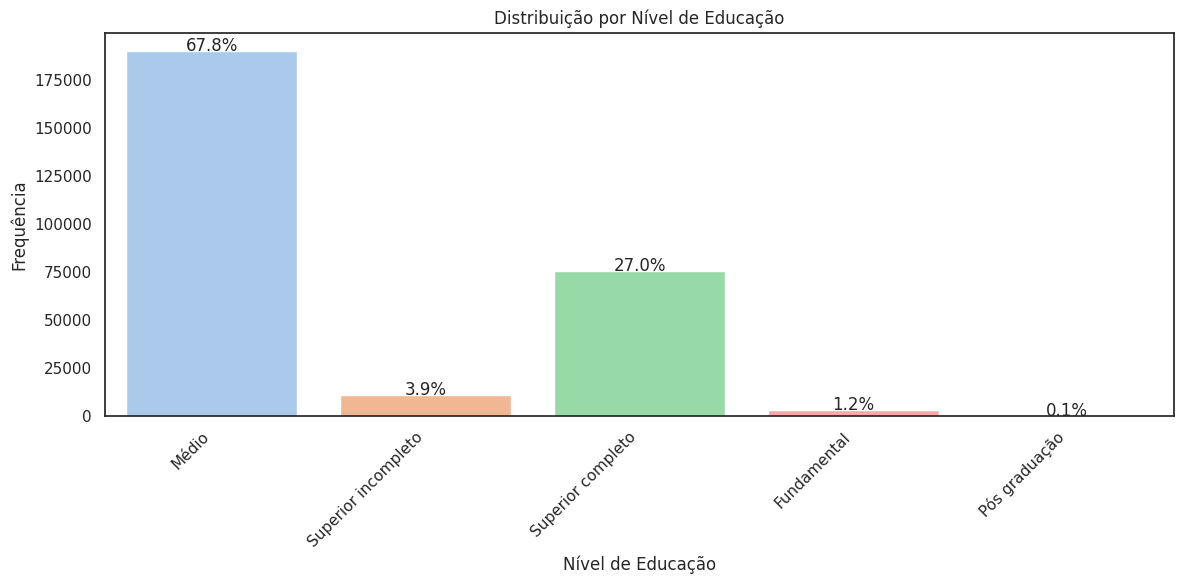

In [70]:
# Definir paleta de cores customizada
colors = sns.color_palette("pastel", n_colors=len(data['educacao'].unique()))

plt.figure(figsize=(12, 6))
sns.countplot(x='educacao', data=data, palette=colors)
plt.xlabel('Nível de Educação')
plt.ylabel('Frequência')
plt.title('Distribuição por Nível de Educação')

# Rotacionar rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Adicionar porcentagens nas barras
total = len(data['educacao'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

# Ajustar layout
plt.tight_layout()

plt.show()

#### Estado Civil

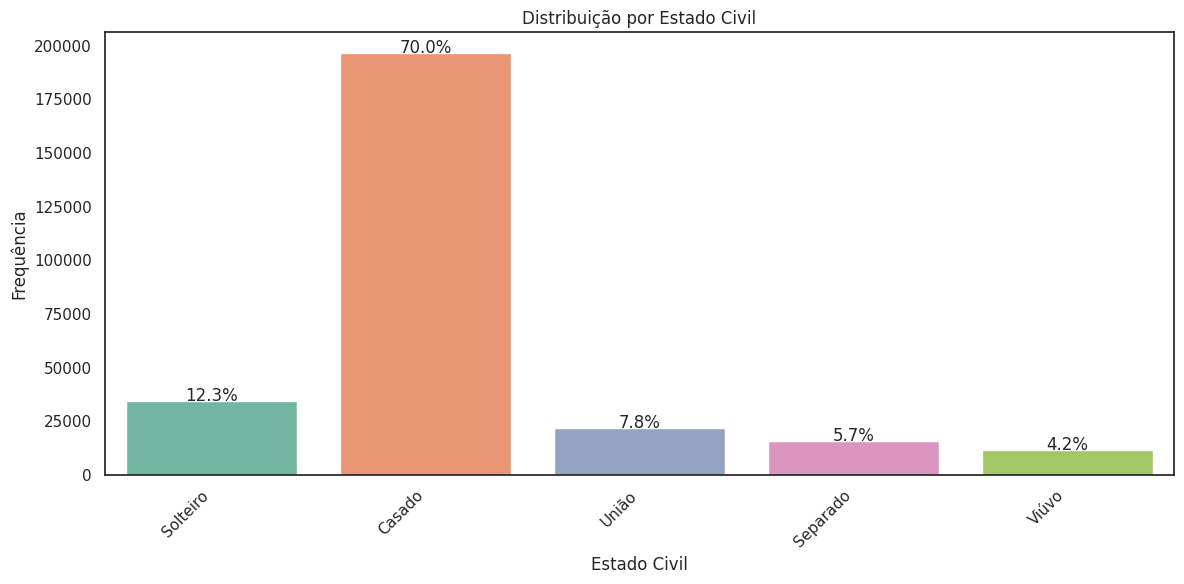

In [71]:
# Definir paleta de cores customizada
colors = sns.color_palette("Set2", n_colors=len(data['estado_civil'].unique()))

plt.figure(figsize=(12, 6))
sns.countplot(x='estado_civil', data=data, palette=colors)
plt.xlabel('Estado Civil')
plt.ylabel('Frequência')
plt.title('Distribuição por Estado Civil')

# Rotacionar rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Adicionar porcentagens nas barras
total = len(data['estado_civil'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

# Ajustar layout
plt.tight_layout()

plt.show()

#### Tipo de Residencia

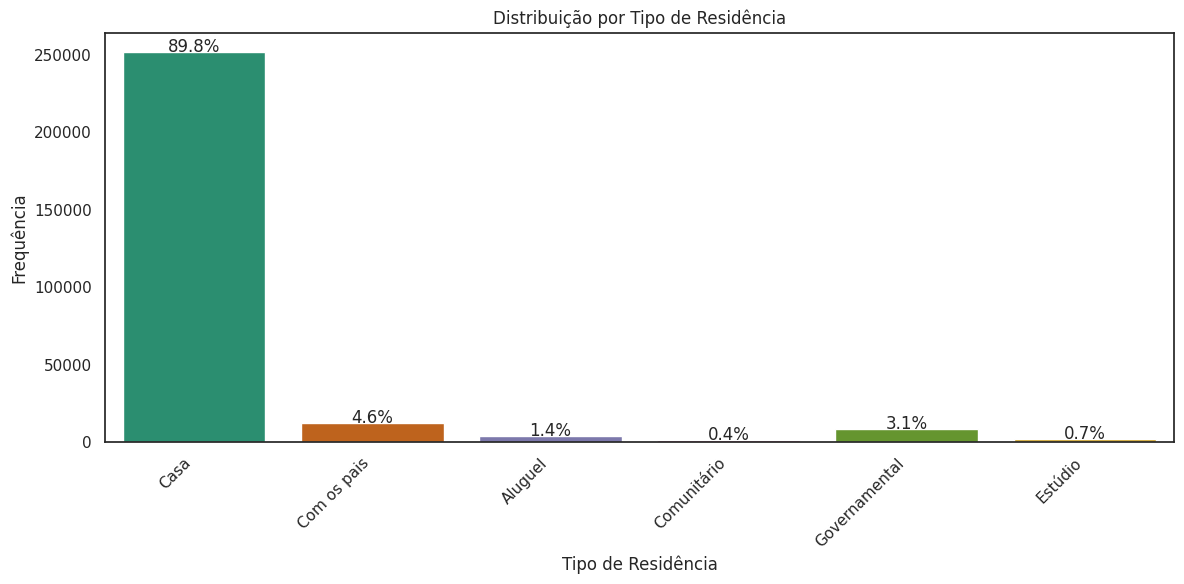

In [73]:
# Definir paleta de cores customizada
colors = sns.color_palette("Dark2", n_colors=len(data['tipo_residencia'].unique()))

plt.figure(figsize=(12, 6))
sns.countplot(x='tipo_residencia', data=data, palette=colors)
plt.xlabel('Tipo de Residência')
plt.ylabel('Frequência')
plt.title('Distribuição por Tipo de Residência')

# Rotacionar rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Adicionar porcentagens nas barras
total = len(data['tipo_residencia'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

# Ajustar layout
plt.tight_layout()

plt.show()


### Perfil Demográfico e Socioeconômico do Grupo

O panorama desse grupo de pessoas revela um perfil diversificado. Aqui estão algumas das principais características:

- **Idade Média:** A média de idade é de 43 anos, indicando uma ampla distribuição etária.

- **Renda Média:** A média de renda é de 8 mil reais, abrangendo uma faixa variada de situações financeiras.

- **Sexo:** A maioria é do sexo feminino, representando 67% do grupo, enquanto os homens compõem os 33% restantes.

- **Mobilidade:** É notável que 61% do grupo escolheu não possuir um veículo, refletindo uma opção consciente em relação à mobilidade.

- **Habitação:** Cerca de um terço do grupo (33.4%) não possui imóvel próprio, indicando diversidade nas opções de residência.

- **Educação:** A predominância de pessoas com ensino médio (67%) sugere um nível educacional intermediário.

- **Estado Civil:** A maioria é casada, representando 70% do grupo, destacando a relevância das relações familiares.

Essa combinação de características revela a diversidade e dinâmica desse grupo, refletindo estágios de vida distintos, escolhas financeiras e pessoais variadas.

